In [1]:
import pickle
import torch 
import control as ct
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from cr3bp import EarthMoon
import cr3bp
from random import randint
import numpy.random as npr
from matplotlib import pyplot as plt, patches
import matplotlib as mpl
import torch.optim as optim
from torch.utils.data import random_split
from numpy import linalg as LA
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

print(torch.cuda.is_available())
!nvidia-smi
device = torch.device("cuda:0")

True
Mon Mar  4 15:58:00 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 30%   60C    P2   149W / 350W |   1486MiB / 24576MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [2]:
# function to output the time derivative state space dynamics of the satellite in the CR3BP
def CR3BPdyn(t,x,mu):
    
    ax = x[0]+2*x[4]-((1-mu)*(x[0]+mu))/((x[0]+mu)**2+x[1]**2+x[2]**2)**(3/2)-(mu*(x[0]-(1-mu)))/((x[0]-(1-mu))**2+x[1]**2+x[2]**2)**(3/2) # acceleration in x-dir based on CR3BP
    ay = x[1]-2*x[3]-((1-mu)*x[1])/((x[0]+mu)**2+x[1]**2+x[2]**2)**(3/2)-(mu*x[1])/((x[0]-(1-mu))**2+x[1]**2+x[2]**2)**(3/2) # acceleration in y-dir based on CR3BP
    az = -((1-mu)*x[2])/((x[0]+mu)**2+x[1]**2+x[2]**2)**(3/2)-(mu*x[2])/((x[0]-(1-mu))**2+x[1]**2+x[2]**2)**(3/2) # acceleration in z-dir based on CR3BP

    fdyn = np.array([x[3], x[4], x[5], ax, ay, az])
    return fdyn


# runge-kutta fourth-order numerical integration
def rk4(func, tk, _yk, mu, _dt, **kwargs):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk, mu, **kwargs)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)), mu, **kwargs)
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)), mu, **kwargs)
    f4 = func(tk + _dt, _yk + (f3 * _dt), mu, **kwargs)

    # return an average of the derivative over tk, tk + dt
    return np.array(_yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4))

In [3]:
# CR3BP parameters
G = 6.67408E-20  # Univ. Gravitational Constant [km3 kg-1 s-2]
mEarth = 5.97219E+24  # Mass of the Earth [kg]
mMoon = 7.34767E+22  # Mass of the Moon [kg]
a = 3.844E+5  # Semi-major axis of Earth and Moon [km]
m1 = mEarth
m2 = mMoon
Mstar = m1+m2  # ND Mass Parameter
Lstar = a  # ND Length Parameter
Tstar = (Lstar**3/(G*Mstar))**(1/2)  # ND Time Parameter
mu = m2/Mstar

number_of_initial_conditions = 500
dp = 2000
tf = 90*86400/Tstar
nx = 6 # state space representation of the model has 4 states
m = 3 # number of control states
predict_time = 25

# creating empty vectors to store data
data_x = torch.zeros((0,dp-predict_time+1, nx))
data_y = torch.zeros((0,dp-predict_time+1, nx))
data_y2 = torch.zeros((0,dp-predict_time+1, nx))

# looping through all the initial conditions
for num in range(number_of_initial_conditions):

    EM = cr3bp.EarthMoon
    eoms = cr3bp.EOMConstructor(EM.mu)
    randomiser = 1 + num/10000
    IC = [randomiser*EM.L1 + 1/EM.l, 0, 0, 0, 0, 0]
    IC[3:5] = cr3bp.initial_velocity(IC[:2], EM.L1, EM.mu)
    x0_CR3BP = IC
    time = np.linspace(0, int(tf), dp)
    dt = tf/dp
    xk = x0_CR3BP
    sol = np.empty([6,])
    X = np.empty([nx,])
    Y = np.empty([nx,])

    for t in time:
        X = np.vstack((X, xk))
        xk = rk4(CR3BPdyn, t, xk, mu, dt) # RK4 approximation of solution
        Y = np.vstack((Y, xk))

    X = torch.FloatTensor(X)
    Y = torch.FloatTensor(Y)

    newx = X[1:-(predict_time-1),:]
    newy = Y[predict_time:,:]
    newy2 = Y[1:-(predict_time-1),:]

    # storing in one large data array
    data_x = torch.vstack([data_x, newx[None,:]])  
    data_y = torch.vstack([data_y, newy[None,:]])
    data_y2 = torch.vstack([data_y2, newy2[None,:]])

In [4]:
# train-test split for evaluation of the model
loader = DataLoader(list(zip(data_x, data_y, data_y2)), shuffle=True, batch_size=200)

# ***Building the Network***

In [5]:
# Hyper-parameters j
input_size = nx 
lifted_space = 100
hidden_size = 105
learning_rate = 0.000001
P = torch.cat((torch.eye(nx),torch.zeros(nx,lifted_space)),1).to(device)

class Encoder(nn.Module):
    def __init__(self, input_size, lifted_space):
        super(Encoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, lifted_space)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
          encoded = self.encoder(x)
          return encoded         

modelen = Encoder(input_size, lifted_space).to(device)
criterion = torch.nn.MSELoss().to(device) # mean squared loss 
optimizer = optim.Adamax(list(modelen.parameters()), lr=learning_rate, weight_decay=1e-5)

# ***Training***

In [6]:
num_epochs = 10000
Loss = []
Loss_prev = 1e38
num_tests = 50
iterations = 7
dp = 1976

for iter in range(iterations): 
    i = 0
    j = 0

    for epoch in range(num_epochs):
        # ~~~~~~~~~~~~~~ for batch training 3D array ~~~~~~~~~~~~~~~~~#
        for part_x, part_y, part_y2 in loader:

            #~~~~~~~~~~~~~~~~ original data type, constant dp, 3D array ~~~~~~~~~~~~~~~~~~~~~~#
            part_x = part_x.reshape([int(len(part_x)*(dp)),nx]).to(device) # reshaping to stack all initial conditions on top of each other
            part_y = part_y.reshape([int(len(part_y)*(dp)),nx]).to(device) # reshaping to stack all initial conditions on top of each other
            part_y2 = part_y2.reshape([int(len(part_y2)*(dp)),nx]).to(device) # reshaping to stack all initial conditions on top of each other
            transpose_y_train  = torch.transpose(part_y,0,1).to(device)    # transpose to fit the model
            transpose_y2_train  = torch.transpose(part_y2,0,1).to(device)    # transpose to fit the model
            transpose_x_train  = torch.transpose(part_x,0,1).to(device)    # transpose to fit the model

            phi_k = torch.transpose(modelen(part_x.to(device)),0,1).to(device)    # encoded x data
            K_phi_k = torch.cat((transpose_x_train,phi_k),0).to(device)           # adding the original states to the encoded x data

            phi_k_plus_one = torch.transpose(modelen(part_y2.to(device)),0,1).to(device)   # encoded y data
            K_phi_k_plus_one = torch.cat((transpose_y2_train,phi_k_plus_one),0).to(device) # adding the original states to the encoded y data
            
            #~~~~~~~~~~~~~~~~~~~~~ EDMD ~~~~~~~~~~~~~~~~~~~~~~#

            K = torch.matmul(K_phi_k_plus_one,torch.pinverse(K_phi_k)) # find Koopman K using EDMD


            #~~~~~~~~~~~~~~~ One Time Step Prediction loss ~~~~~~~~~~~~~~~~~~~~~~#

            K_phi_plus_one = torch.matmul(K,K_phi_k) #+ torch.matmul(B,transpose_u_train)

            x_plus_one = torch.matmul(P,K_phi_plus_one)

            # Forward pass and loss calculation
            loss_2 = criterion(x_plus_one, transpose_y2_train) # Koopman loss (finds K) EDMD loss
            
            #~~~~~~~~~~~~~~~~~ Multiple Time Step Predicition Loss ~~~~~~~~~~~~~~~~~#
            # for l in range(predict_time):
            #     next_phi = torch.matmul(K,K_phi_k) #+ torch.matmul(B,transpose_u_train) # K: This is the linear operation. 
            #     next_state = torch.matmul(P,next_phi) # extracting the next state
            #     next_state_encoded = modelen(torch.transpose(next_state,0,1).to(device)) # stacking original states on 
            #     K_phi_k = torch.transpose(torch.cat((torch.transpose(next_state,0,1).to(device),next_state_encoded),1),0,1)

            # loss_x = next_state
            # loss_y = transpose_y_train

            # # Forward pass and loss calculation
            # loss_1 = criterion(loss_x, loss_y) # Koopman loss (finds K) EDMD loss

            loss_1 = 0
            loss_1_lambda = 2
            loss_2_lambda = 1
            
            l1_lambda = 0.004
            l1_regularisation = sum(p.norm().sum()
                  for p in modelen.parameters())
            loss_L1 = l1_lambda * l1_regularisation

            l2_lambda = 0.001
            l2_regularisation = sum(p.pow(2.0).sum()
                  for p in modelen.parameters())
            loss_L2 = l2_lambda * l2_regularisation

            loss = loss_1_lambda*loss_1 + loss_2_lambda*loss_2 + loss_L1 + loss_L2
            
            # Backward and optimize
            optimizer.zero_grad() # find the gradients.
            loss.backward(retain_graph=True)       # needed for multiple loss functions.  Not need for one loss function. We have 2.
            optimizer.step()      # updates the weights for the each parameter.

            # storing the K and PK values and model of the best model trained so far
            if loss.item() < Loss_prev or (iter == 0 and epoch == 0):
                best_model = modelen
                K_best = K
                Loss_prev = loss.item()
            modelen = best_model

                # logging of losses
        if (i+1) % 100 == 0:
            print (f'Iteration: [{iter+1}/{iterations}],   Epoch: [{epoch+1}/{num_epochs}],  Loss: {loss.item():.15f},   L1 Loss: {loss_L1}, L2 Loss: {loss_L2}')
        i = i+1
        Loss.append(loss.item())

Iteration: [1/7],   Epoch: [100/10000],  Loss: 1.913252472877502,   L1 Loss: 0.5446221828460693, L2 Loss: 1.36861252784729
Iteration: [1/7],   Epoch: [200/10000],  Loss: 1.904567480087280,   L1 Loss: 0.5431842803955078, L2 Loss: 1.361364483833313
Iteration: [1/7],   Epoch: [300/10000],  Loss: 1.895905733108521,   L1 Loss: 0.5417476296424866, L2 Loss: 1.3541420698165894
Iteration: [1/7],   Epoch: [400/10000],  Loss: 1.887284755706787,   L1 Loss: 0.5403122901916504, L2 Loss: 1.3469452857971191
Iteration: [1/7],   Epoch: [500/10000],  Loss: 1.878683805465698,   L1 Loss: 0.538878321647644, L2 Loss: 1.3397746086120605
Iteration: [1/7],   Epoch: [600/10000],  Loss: 1.870092749595642,   L1 Loss: 0.5374456644058228, L2 Loss: 1.3326295614242554
Iteration: [1/7],   Epoch: [700/10000],  Loss: 1.861544013023376,   L1 Loss: 0.5360142588615417, L2 Loss: 1.3255102634429932
Iteration: [1/7],   Epoch: [800/10000],  Loss: 1.853017568588257,   L1 Loss: 0.5345840454101562, L2 Loss: 1.3184161186218262
Iter

OutOfMemoryError: CUDA out of memory. Tried to allocate 160.00 MiB (GPU 0; 23.68 GiB total capacity; 20.39 GiB already allocated; 122.31 MiB free; 20.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

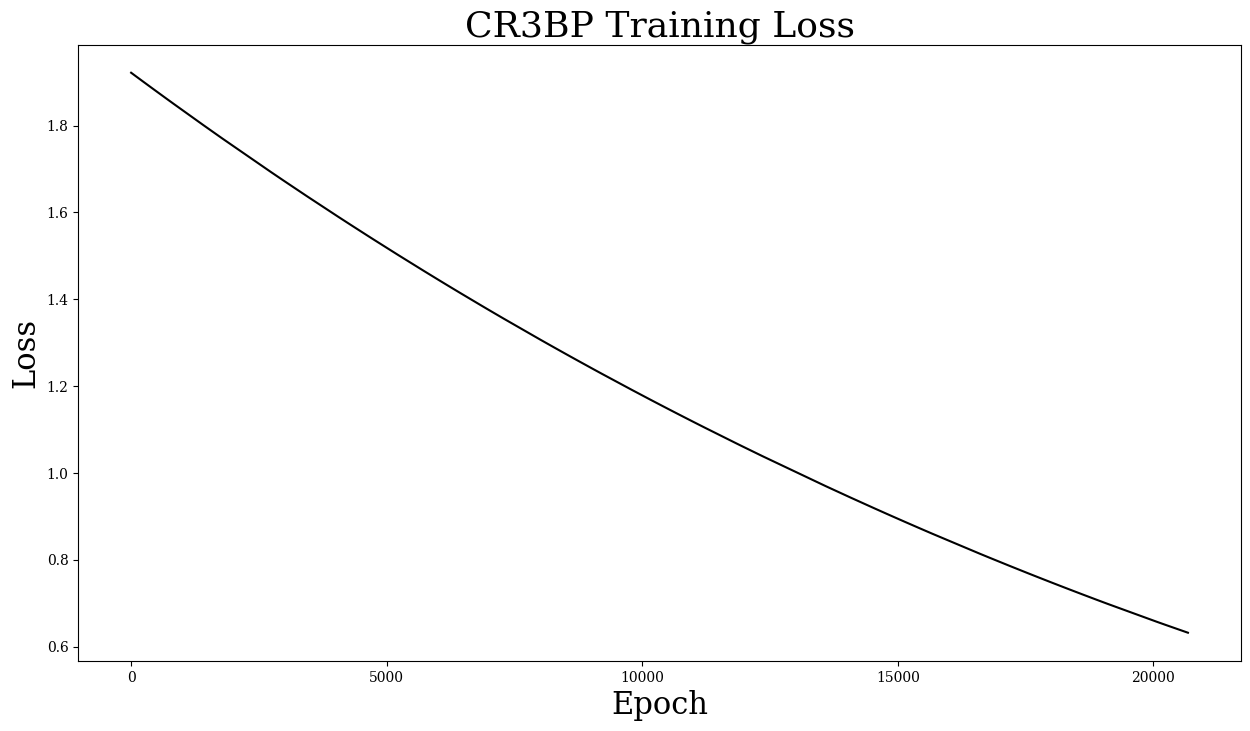

In [7]:
# plotting training loss
mpl.rc('font',family='Serif')
fig, ax = plt.subplots(figsize = (15, 8))
lns = ax.plot(Loss, color='black', label = 'RLDK model')
ax.set_xlabel("Epoch", fontsize = 22)
ax.set_ylabel('Loss', fontsize = 22)
ax.set_title("CR3BP Training Loss", fontsize=26)
plt.show()

In [9]:
modelen = best_model
K = K_best

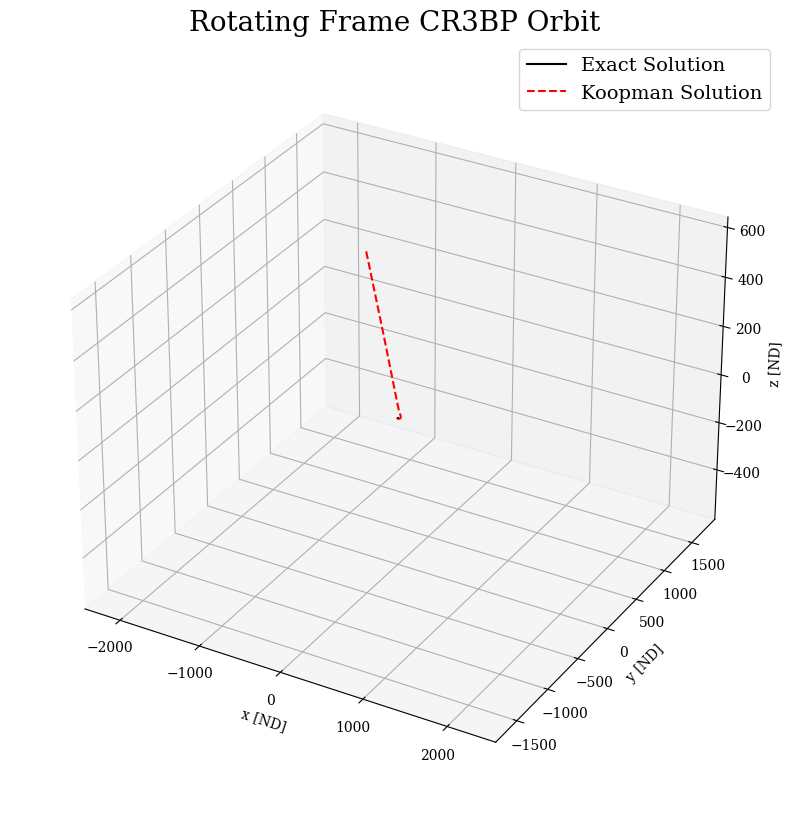

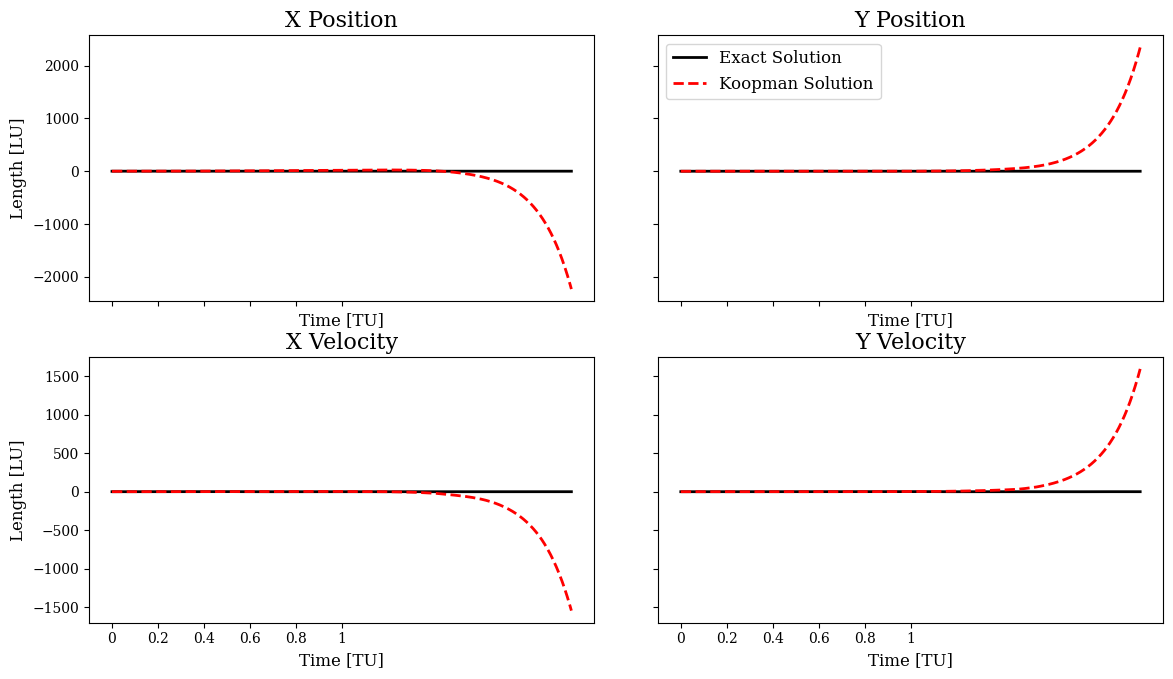

In [14]:
# CR3BP parameters
G = 6.67408E-20  # Univ. Gravitational Constant [km3 kg-1 s-2]
mEarth = 5.97219E+24  # Mass of the Earth [kg]
mMoon = 7.34767E+22  # Mass of the Moon [kg]
a = 3.844E+5  # Semi-major axis of Earth and Moon [km]
m1 = mEarth
m2 = mMoon
Mstar = m1+m2  # ND Mass Parameter
Lstar = a  # ND Length Parameter
Tstar = (Lstar**3/(G*Mstar))**(1/2)  # ND Time Parameter
mu = m2/Mstar

tf = 90*86400/Tstar
dp = 2000

EM = cr3bp.EarthMoon
eoms = cr3bp.EOMConstructor(EM.mu)
randomiser = 1 + randint(0,499)/10000 + randint(1,9)/100000
IC = [randomiser*EM.L1 + 1/EM.l, 0, 0, 0, 0, 0]
IC[3:5] = cr3bp.initial_velocity(IC[:2], EM.L1, EM.mu)
x0_CR3BP = torch.tensor(IC).type(torch.FloatTensor)
time = np.linspace(0, tf, dp)
dt = tf/dp
xk = x0_CR3BP
sol = np.empty([6,])
X = np.empty([nx,])
initial_phi_without_states = torch.transpose(modelen(x0_CR3BP.to(device)),0,0)
initial_phi = torch.cat((torch.transpose(x0_CR3BP.to(device),0,0),initial_phi_without_states),0).cpu()

# ~~~~~~ Creating tensors to store system states ~~~~~~~ #
new_states = torch.zeros(nx,dp).cpu()
next_state = x0_CR3BP
phi_i = initial_phi
i=0
# ~~~~~~ System Evolution ~~~~~~~ #
for t in time:

    # ~~~~~~~ Koopman Model with Kalman Filter ~~~~~~~ #
    new_states[:,i] = next_state # saving states
    phi_ip1 = torch.matmul(K.cpu(), phi_i)
    next_state = torch.matmul(P.cpu(),phi_ip1).cpu() # extracting the next state
    next_state_encoded = torch.transpose(modelen(next_state.to(device)),0,0) # stacking original states on 
    phi_i = torch.cat((next_state.to(device),next_state_encoded),0).cpu()
    
    # ~~~~~~~ Exact Nonlinear Dynamics ~~~~~~~~ #
    sol = np.vstack((sol, xk))
    xk = rk4(CR3BPdyn, t, xk, mu, dt) # RK4 approximation of solution
    i = i+1

sol = sol[1:,:]

X_true = sol[:,0]
Y_true = sol[:,1]
Z_true = sol[:,2]

new_states = torch.transpose(new_states,0,1).detach().numpy()
X_lin = new_states[:,0]
Y_lin = new_states[:,1]
Z_lin = new_states[:,2]

m1_loc = [-mu, 0, 0]
m2_loc = [(1-mu), 0, 0]

# Rotating Frame Plot
mpl.rc('font',family='Serif')
fig = plt.figure(figsize = (15, 10))
# fig.tight_layout(pad = 3.0)
ax = plt.axes(projection='3d')
ax.set_box_aspect(aspect=None,zoom=0.95)

# Adding Figure Title and Labels
ax.set_title('Rotating Frame CR3BP Orbit', fontsize=20)
ax.set_xlabel('x [ND]')
ax.set_ylabel('y [ND]')
ax.set_zlabel('z [ND]')

# Plotting Rotating Frame Positions
u = np.linspace(0,2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(m1_loc[0]+0.1*x, m1_loc[1]+0.075*y, m1_loc[2]+0.032*z, color='blue',)
ax.plot_surface(m2_loc[0]+0.05*x, m2_loc[1]+0.0375*y, m2_loc[2]+0.0175*z, color='grey')

ax.plot3D(X_true, Y_true, Z_true, c='black', label='Exact Solution')
ax.plot3D(X_lin, Y_lin, Z_lin, c='red',label='Koopman Solution', linestyle='--')

# ax.plot3D(m1_loc[0], m1_loc[1], m1_loc[2], c='blue', label='Earth', marker='o')
# ax.plot3D(m2_loc[0], m2_loc[1], m2_loc[2], c='grey', label='Moon', marker='o')
ax.legend(fontsize=14)

# Setting Axis Limits
xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim * 3/4)
ax.set_zlim3d(XYZlim * 1/4)

# Plotting states
fig2, ax2 = plt.subplots(2, 2, sharex = 'col', sharey = 'row', figsize = (12, 7))
fig2.tight_layout(pad = 3.0)
colours = ['black', 'red','deepskyblue']
line = ['-', '--',':']
titles = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
plot_lines = []
for i in range(4):
    if i == 0:
        a = 0
        b = 0
        j = 0
    elif i == 1:
        a = 0
        b = 1
        j = 1
    elif i == 2:
        a = 1
        b = 0
        j = 3
    elif i == 3:
        a = 1
        b = 1
        j = 4
    p1, = ax2[a,b].plot(sol[:,j], color=colours[0], linestyle=line[0], label='Exact Solution', linewidth=2)
    p2, = ax2[a,b].plot(new_states[:,j], color=colours[1], linestyle=line[1], label='Koopman Solution', linewidth=2)
    ax2[a,b].set_title(titles[i], fontsize = 16)
    ax2[a,b].set_xlabel("Time [TU]", fontsize = 12)
    ax2[a,0].set_ylabel("Length [LU]", fontsize = 12)
ax2[0,1].legend(fontsize=12)
ax2[1,0].set_xticks([0, 200, 400, 600, 800, 1000],[0, 0.20, 0.40, 0.60, 0.80, 1])
ax2[1,1].set_xticks([0, 200, 400, 600, 800, 1000],[0, 0.20, 0.40, 0.60, 0.80, 1])

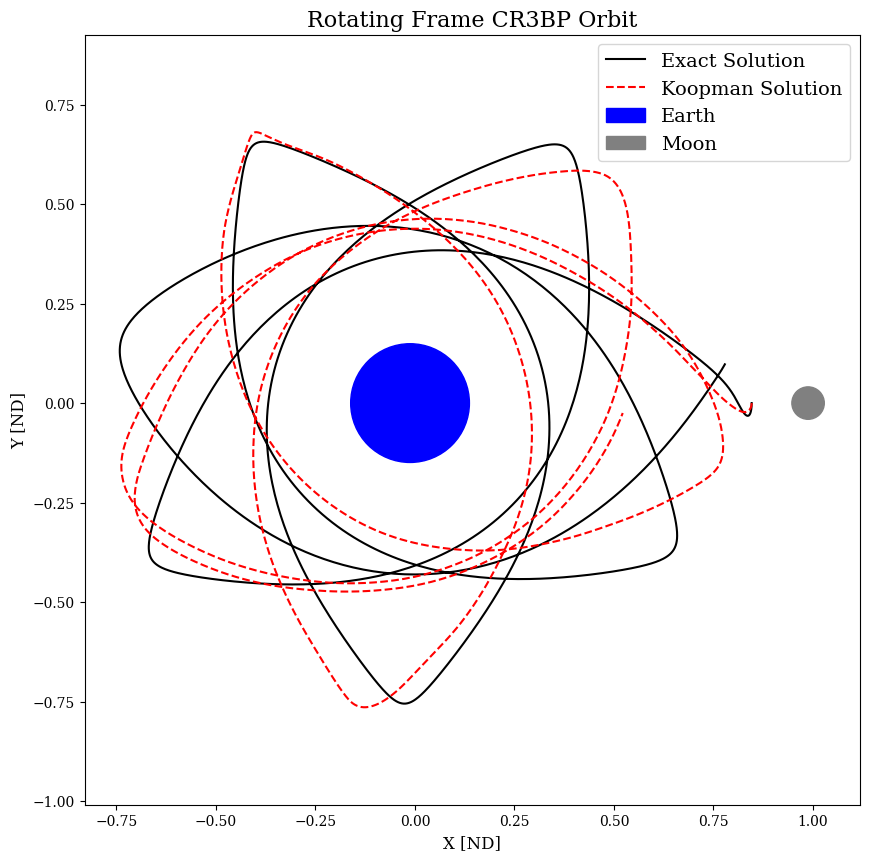

In [ ]:
fig3 = plt.figure(figsize = (10, 10))
ax3 = plt.axes()

# Adding Figure Title and Labels
ax3.set_title('Rotating Frame CR3BP Orbit', fontsize=16)
ax3.set_xlabel('X [ND]', fontsize=12)
ax3.set_ylabel('Y [ND]', fontsize=12)


# Plotting Rotating Frame Positions
ax3.plot(X_true, Y_true, c='black', label='Exact Solution')
ax3.plot(X_lin, Y_lin, linestyle='--', c='red', label='Koopman Solution')
Earth = patches.Circle((m1_loc[0], m1_loc[1]), 9*6370/Lstar, color='blue', label='Earth')
Moon = patches.Circle((m2_loc[0], m2_loc[1]), 9*1740/Lstar, color='grey', label='Moon')

ax3.add_patch(Earth)
ax3.add_patch(Moon)
ax3.axis('equal')
ax3.legend(fontsize=14)

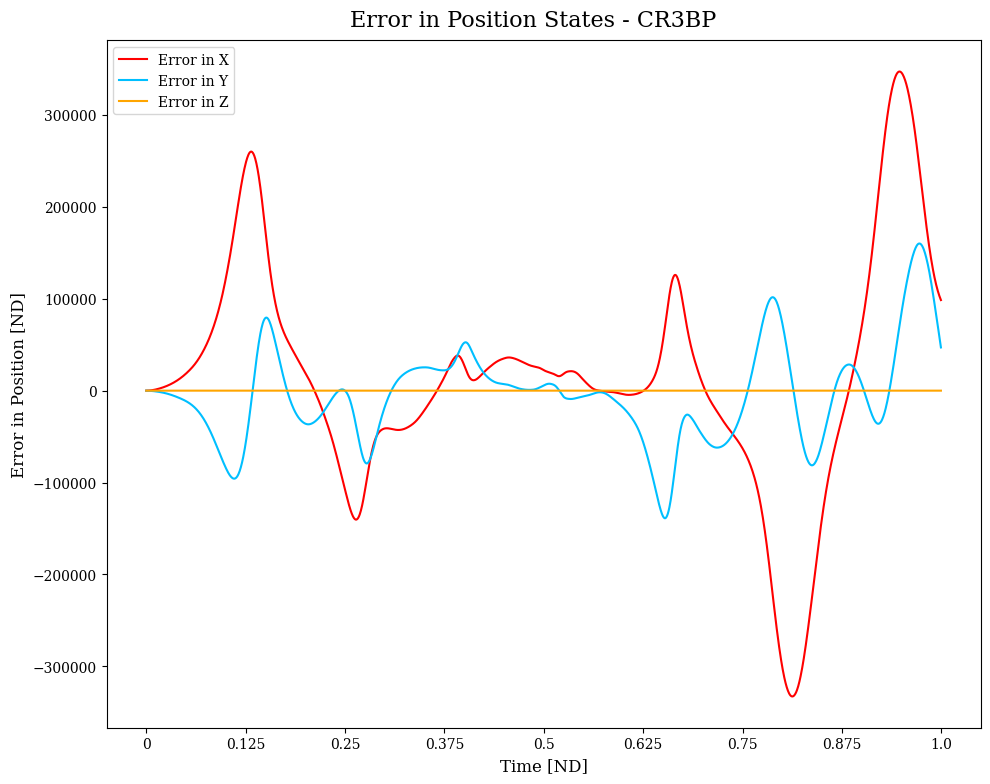

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
errorX = (sol[:,0]*Lstar - new_states[:,0]*Lstar)
errorY = (sol[:,1]*Lstar - new_states[:,1]*Lstar)
errorZ = (sol[:,2]*Lstar - new_states[:,2]*Lstar)

colours = ['black', 'red','deepskyblue', 'orange', 'pink', 'silver']

# Setting up Error plot
fig4 = plt.figure(figsize = (10,8))
ax4 = plt.axes()
fig4.tight_layout(pad = 3.0)

ax4.plot(errorX, color=colours[1], label='Error in X')
ax4.plot(errorY, color=colours[2], label = 'Error in Y')
ax4.plot(errorZ, color=colours[3], label = 'Error in Z')
ax4.set_xlabel('Time [ND]', fontsize = 12)
ax4.set_ylabel('Error in Position [ND]', fontsize = 12)
ax4.legend()
fig4.suptitle('Error in Position States - CR3BP', fontsize = 16)
ax4.set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],[0, 0.125, 0.25, 0.375, 0.500, 0.625, 0.750, 0.875, 1.00])

# ***Metrics***

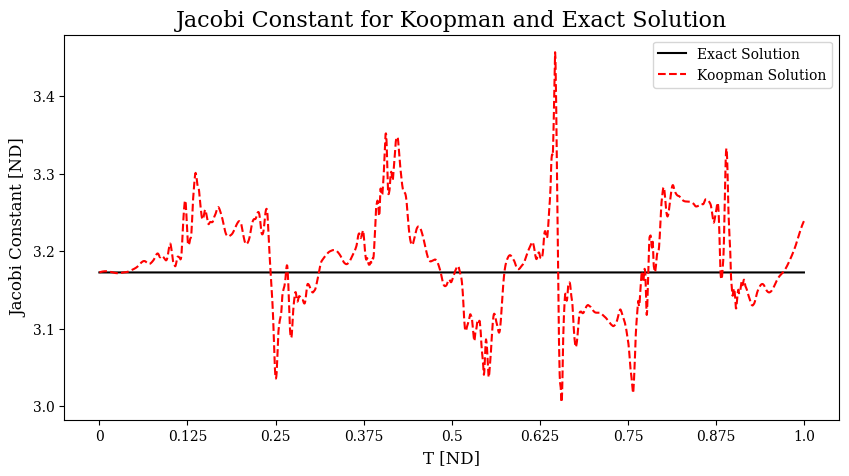

In [ ]:
def Jacobi3(states,mu):
    x = states[:,0]
    y = states[:,1]
    z = states[:,2]
    xdot = states[:,3]
    ydot = states[:,4]
    zdot = states[:,5]

    mu1 = 1-mu
    mu2 = mu
    r1 = np.sqrt((x+mu2)**2 + y**2 + z**2)
    r2 = np.sqrt((x-mu1)**2 + y**2 + z**2)
 
    return (x**2 + y**2) + 2*(mu1/r1 + mu2/r2) - xdot**2 - ydot**2 - zdot**2

true = Jacobi3(sol,mu)
exp = Jacobi3(new_states,mu)
fig5 = plt.figure(figsize = (10, 5))
ax5 = plt.axes()

# Adding Figure Title and Labels
ax5.set_title('Jacobi Constant for Koopman and Exact Solution', fontsize=16)
ax5.set_xlabel('T [ND]', fontsize=12)
ax5.set_ylabel('Jacobi Constant [ND]', fontsize=12)
ax5.set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],[0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.75, 0.875, 1.00])

# Plotting Rotating Frame Positions
ax5.plot(true, c='black')
ax5.plot(exp, linestyle='--', c='red')
ax5.legend(labels=['Exact Solution', 'Koopman Solution'])